*Dataset Format*

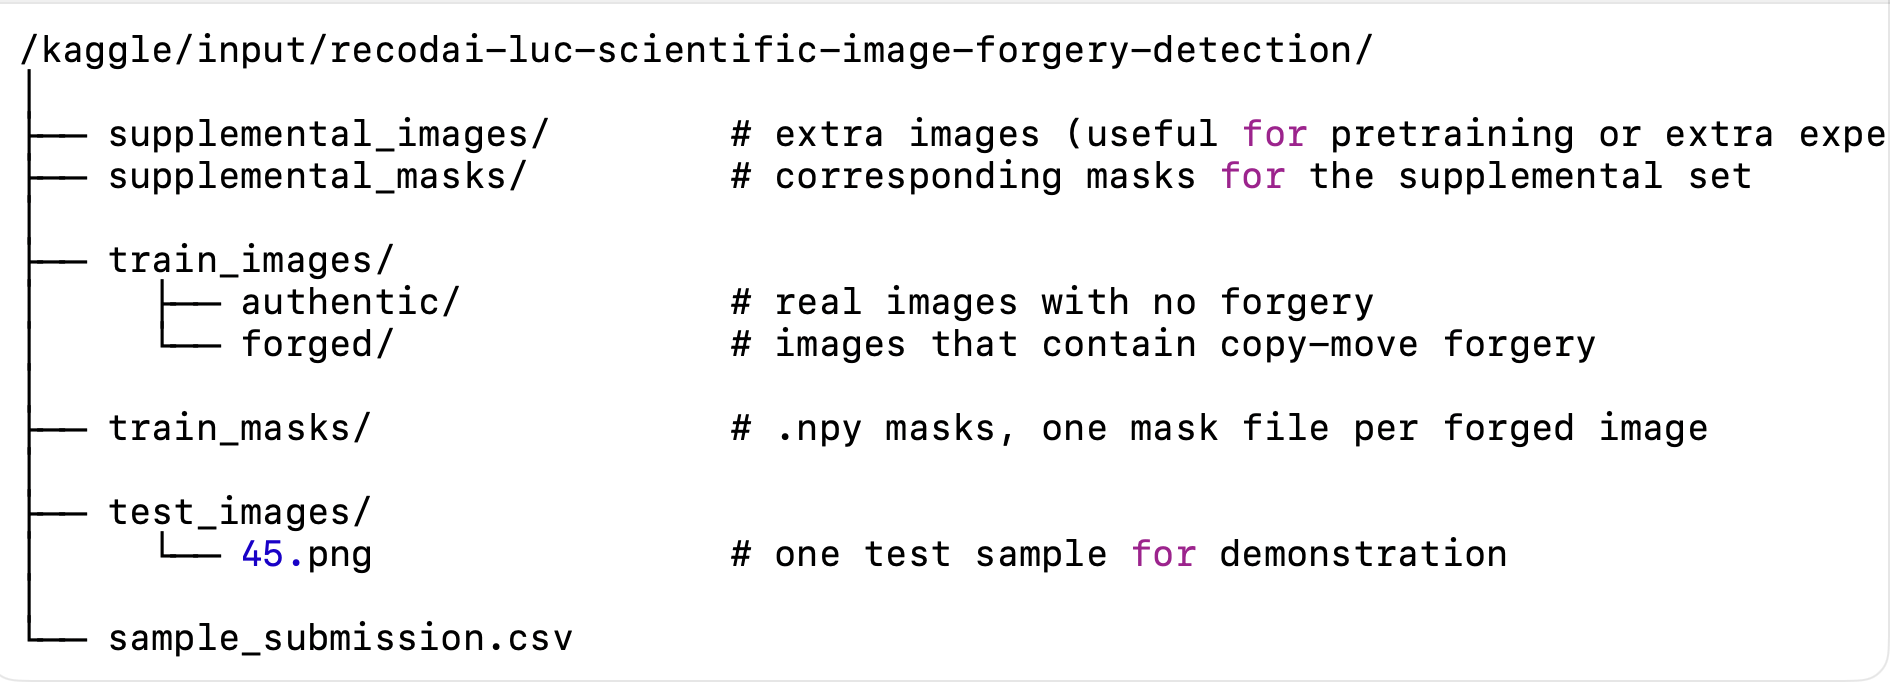

**Understanding Problem and Collecting the data**

In [1]:
import os
import numpy as np
from PIL import Image

base = "/kaggle/input/recodai-luc-scientific-image-forgery-detection"

paths = {
    "authentic": os.path.join(base, "train_images/authentic"),
    "forged": os.path.join(base, "train_images/forged"),
    "masks": os.path.join(base, "train_masks"),
    "supp_imgs": os.path.join(base, "supplemental_images"),
    "supp_masks": os.path.join(base, "supplemental_masks"),
    "test": os.path.join(base, "test_images"),
}

# Counting no of images
num_authentic = len(os.listdir(paths["authentic"]))
num_forged = len(os.listdir(paths["forged"]))
num_masks = len(os.listdir(paths["masks"]))

print("Authentic images:", num_authentic)
print("Forged images:", num_forged)
print("Mask files:", num_masks)

Authentic images: 2377
Forged images: 2751
Mask files: 2751


In [2]:
# Checking filename matching
forged_files = sorted(os.listdir(paths["forged"]))
mask_files = sorted(os.listdir(paths["masks"]))

for i in range(6):
    print(f"Forged: {forged_files[i]}  -> Mask: {mask_files[i]}")

Forged: 10.png  -> Mask: 10.npy
Forged: 10015.png  -> Mask: 10015.npy
Forged: 10017.png  -> Mask: 10017.npy
Forged: 10030.png  -> Mask: 10030.npy
Forged: 10070.png  -> Mask: 10070.npy
Forged: 1008.png  -> Mask: 1008.npy


In [3]:
# Analyzing mask shapes & values
sample_mask_path_0= os.path.join(paths["masks"], mask_files[0])
sample_mask_path_1 = os.path.join(paths["masks"], mask_files[1])
sample_mask_path_2 = os.path.join(paths["masks"], mask_files[2])
mask_0 = np.load(sample_mask_path_0)
mask_1 = np.load(sample_mask_path_1)
mask_2 = np.load(sample_mask_path_2)

print("Sample mask shape of First mask:", mask_0.shape)
print("Sample mask shape of Second mask:", mask_1.shape)
print("Sample mask shape of Third mask:", mask_2.shape)
print("dtype:", mask_0.dtype)
print("dtype:", mask_1.dtype)
print("Unique values:", np.unique(mask_0)[:10])
print("Unique values:", np.unique(mask_1)[:10])

Sample mask shape of First mask: (1, 512, 648)
Sample mask shape of Second mask: (1, 1200, 1600)
Sample mask shape of Third mask: (1, 256, 320)
dtype: uint8
dtype: uint8
Unique values: [0 1]
Unique values: [0 1]


In [4]:
# Checking shape mismatches
bad_shapes = []
for mf in mask_files:
    m = np.load(os.path.join(paths["masks"], mf))
    if not (m.ndim == 2 or (m.ndim == 3 and 1 in m.shape)):
        bad_shapes.append((mf, m.shape))

print("Masks with unusual shapes:", bad_shapes[:10])

Masks with unusual shapes: [('10070.npy', (2, 712, 414)), ('10139.npy', (3, 846, 759)), ('10176.npy', (2, 666, 1000)), ('10266.npy', (2, 666, 1000)), ('10307.npy', (2, 1200, 1600)), ('10348.npy', (2, 256, 320)), ('10435.npy', (2, 422, 1137)), ('1070.npy', (3, 520, 696)), ('10730.npy', (2, 666, 1000)), ('10855.npy', (2, 360, 360))]


In [5]:
# Checking a few forged image shapes
sizes = []
for img_name in forged_files[:10]:
    img = Image.open(os.path.join(paths["forged"], img_name))
    sizes.append(img.size)  # (W, H)

print("Forged image sample sizes:", sizes)

Forged image sample sizes: [(648, 512), (1600, 1200), (320, 256), (1000, 666), (414, 712), (1310, 158), (2592, 3888), (759, 846), (2568, 1912), (1201, 152)]


In [6]:
# Checking a few authentic image shapes
authentic_files = sorted(os.listdir(paths["authentic"]))
sizes = []
for img_name in authentic_files[:10]:
    img = Image.open(os.path.join(paths["authentic"], img_name))
    sizes.append(img.size)  # (W, H)

print("authentic image sample sizes:", sizes)

authentic image sample sizes: [(648, 512), (1600, 1200), (320, 256), (1000, 666), (414, 712), (1310, 158), (2592, 3888), (759, 846), (2568, 1912), (1201, 152)]


In [7]:
import numpy as np

def load_mask(mask_path):
    """
    Loads a mask and returns a list of (H,W) binary masks.
    Handles:
    - (1,H,W)  -> 1 instance
    - (C,H,W)  -> C instances
    """
    m = np.load(mask_path)

    # ensure uint8 binary
    m = (m > 0).astype(np.uint8)

    # case: (H,W)
    if m.ndim == 2:
        return [m]

    # case: (C,H,W)
    if m.ndim == 3:
        inst_list = []
        for c in range(m.shape[0]):
            inst = m[c]
            if inst.sum() > 0:
                inst_list.append(inst)
        return inst_list

    raise ValueError(f"Unexpected mask shape: {m.shape}")

In [8]:
from pathlib import Path

mask_dir = Path("/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_masks")

test_files = ["10.npy", "10070.npy", "10139.npy"]

for f in test_files:
    insts = load_mask(mask_dir / f)
    print(f, "instances:", len(insts))
    for i, m in enumerate(insts):
        print("  shape:", m.shape, "pixels:", m.sum())

10.npy instances: 1
  shape: (512, 648) pixels: 928
10070.npy instances: 2
  shape: (712, 414) pixels: 5742
  shape: (712, 414) pixels: 6951
10139.npy instances: 3
  shape: (846, 759) pixels: 1188
  shape: (846, 759) pixels: 1233
  shape: (846, 759) pixels: 1293


**Data Cleaning and Preparing the data**

In [9]:
# Creating stratified train/val CSVs for Recod.ai LUC dataset
import os
import json
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit

BASE = Path("/kaggle/input/recodai-luc-scientific-image-forgery-detection")
AUTH_DIR = BASE / "train_images" / "authentic"
FORG_DIR = BASE / "train_images" / "forged"
MASK_DIR = BASE / "train_masks"

In [10]:
def load_mask_list(mask_path: Path):
    m = np.load(mask_path)
    m = (m > 0).astype(np.uint8)
    if m.ndim == 2:
        insts = [m]
    elif m.ndim == 3:
        insts = [m[c] for c in range(m.shape[0]) if m[c].sum() > 0]
    else:
        raise ValueError(f"Unexpected mask shape: {m.shape}")
    return insts

In [11]:
rows = []
# Authentic images (no masks)

for p in sorted(AUTH_DIR.iterdir()):
    if p.suffix.lower() not in (".png", ".jpg", ".jpeg", ".tif", ".tiff"):
        continue
    with Image.open(p) as im:
        w, h = im.size
    rows.append({
        "case_id": p.stem,
        "image_path": str(p),
        "is_forged": 0,
        "mask_path": "",
        "num_instances": 0,
        "mask_pixels": 0,
        "shape": json.dumps([h, w])
    })


In [12]:
# Forged images (masks exist)
for p in sorted(FORG_DIR.iterdir()):
    if p.suffix.lower() not in (".png", ".jpg", ".jpeg", ".tif", ".tiff"):
        continue
    mask_file = MASK_DIR / f"{p.stem}.npy"
    if not mask_file.exists():
        # if no matching mask, warn and skip
        print("Warning: missing mask for", p.name)
        continue
    with Image.open(p) as im:
        w, h = im.size
    insts = load_mask_list(mask_file)
    mask_pixels = sum(int(x.sum()) for x in insts)
    rows.append({
        "case_id": p.stem,
        "image_path": str(p),
        "is_forged": 1,
        "mask_path": str(mask_file),
        "num_instances": len(insts),
        "mask_pixels": mask_pixels,
        "shape": json.dumps([h, w])
    })

In [13]:

df = pd.DataFrame(rows)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

# compute mask_fraction (0 for authentic)
df["area"] = df["shape"].apply(lambda s: json.loads(s)[0] * json.loads(s)[1])
df["mask_fraction"] = df["mask_pixels"] / df["area"]

# create mask fraction bins for stratification
# small epsilon to avoid zero-division; authentic images will be in bin 0
df["mask_frac_bin"] = pd.qcut(df["mask_fraction"] + 1e-12, q=10, duplicates="drop", labels=False)

# stratify key: combine is_forged and mask_frac_bin to preserve both class balance and mask-size distribution
df["strata"] = df["is_forged"].astype(str) + "_" + df["mask_frac_bin"].astype(str)

print("Dataset size:", len(df))
print("Forged / Authentic:", df["is_forged"].value_counts().to_dict())
print("Strata counts (sample):")
print(df["strata"].value_counts())

Dataset size: 5128
Forged / Authentic: {1: 2751, 0: 2377}
Strata counts (sample):
strata
0_0    2377
1_1     513
1_3     513
1_5     513
1_4     513
1_2     512
1_0     187
Name: count, dtype: int64


In [14]:
# Stratified split (80% train / 20% val)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=12345)
train_idx, val_idx = next(sss.split(df, df["strata"]))

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = df.iloc[val_idx].reset_index(drop=True)

print("Train size:", len(train_df), "Val size:", len(val_df))
print("Train forged/authentic:", train_df["is_forged"].value_counts().to_dict())
print("Val forged/authentic:", val_df["is_forged"].value_counts().to_dict())

# Save csvs
OUT_DIR = Path("/kaggle/working")
OUT_DIR.mkdir(parents=True, exist_ok=True)
train_csv = OUT_DIR / "train_split.csv"
val_csv = OUT_DIR / "val_split.csv"
train_df.to_csv(train_csv, index=False)
val_df.to_csv(val_csv, index=False)

print("Saved:", train_csv, val_csv)

Train size: 4102 Val size: 1026
Train forged/authentic: {1: 2200, 0: 1902}
Val forged/authentic: {1: 551, 0: 475}
Saved: /kaggle/working/train_split.csv /kaggle/working/val_split.csv


In [15]:
import pandas as pd

train_df = pd.read_csv("/kaggle/working/train_split.csv")
train_df.head()

,case_id,image_path,is_forged,mask_path,num_instances,mask_pixels,shape,area,mask_fraction,mask_frac_bin,strata
0,44000,/kaggle/input/recodai-luc-scientific-image-for...,1,/kaggle/input/recodai-luc-scientific-image-for...,1,859,"[256, 320]",81920,0.010486,2,1_2
1,12355,/kaggle/input/recodai-luc-scientific-image-for...,0,NaN,0,0,"[666, 1000]",666000,0.000000,0,0_0
2,55300,/kaggle/input/recodai-luc-scientific-image-for...,1,/kaggle/input/recodai-luc-scientific-image-for...,3,2595,"[1104, 1236]",1364544,0.001902,0,1_0
3,7274,/kaggle/input/recodai-luc-scientific-image-for...,1,/kaggle/input/recodai-luc-scientific-image-for...,1,5547,"[520, 696]",361920,0.015327,2,1_2
4,63968,/kaggle/input/recodai-luc-scientific-image-for...,1,/kaggle/input/recodai-luc-scientific-image-for...,3,752,"[513, 512]",262656,0.002863,0,1_0


In [16]:
val_df = pd.read_csv("/kaggle/working/val_split.csv")
val_df.head()

,case_id,image_path,is_forged,mask_path,num_instances,mask_pixels,shape,area,mask_fraction,mask_frac_bin,strata
0,10017,/kaggle/input/recodai-luc-scientific-image-for...,1,/kaggle/input/recodai-luc-scientific-image-for...,1,1175,"[256, 320]",81920,0.014343,2,1_2
1,5506,/kaggle/input/recodai-luc-scientific-image-for...,0,NaN,0,0,"[73, 464]",33872,0.000000,0,0_0
2,55249,/kaggle/input/recodai-luc-scientific-image-for...,0,NaN,0,0,"[666, 1000]",666000,0.000000,0,0_0
3,9086,/kaggle/input/recodai-luc-scientific-image-for...,1,/kaggle/input/recodai-luc-scientific-image-for...,1,12400,"[1024, 1280]",1310720,0.009460,2,1_2
4,44000,/kaggle/input/recodai-luc-scientific-image-for...,0,NaN,0,0,"[256, 320]",81920,0.000000,0,0_0


In [17]:
import pandas as pd

train_df = pd.read_csv("/kaggle/working/train_split.csv")
val_df   = pd.read_csv("/kaggle/working/val_split.csv")

print("=== TRAIN STRATA COUNTS ===")
print(train_df["strata"].value_counts().sort_index())

print("\n=== VAL STRATA COUNTS ===")
print(val_df["strata"].value_counts().sort_index())

=== TRAIN STRATA COUNTS ===
strata
0_0    1902
1_0     150
1_1     410
1_2     410
1_3     410
1_4     410
1_5     410
Name: count, dtype: int64

=== VAL STRATA COUNTS ===
strata
0_0    475
1_0     37
1_1    103
1_2    102
1_3    103
1_4    103
1_5    103
Name: count, dtype: int64


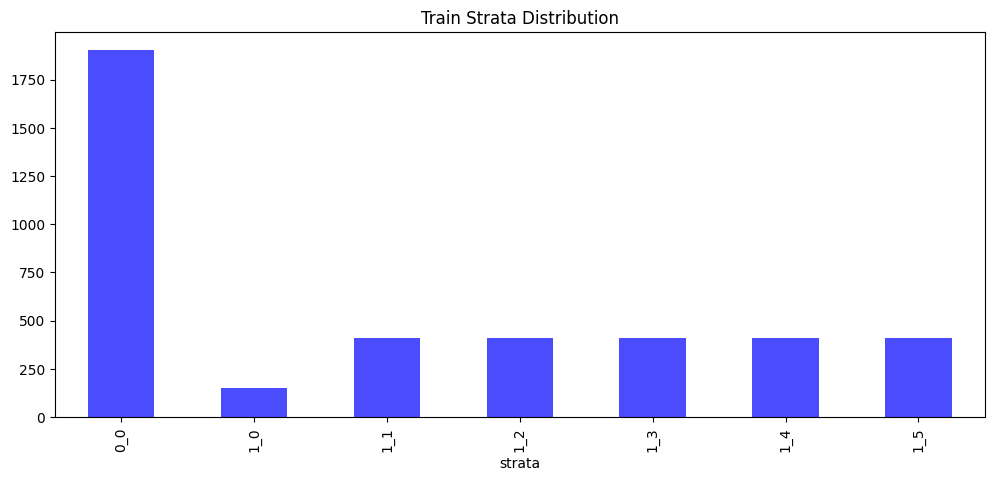

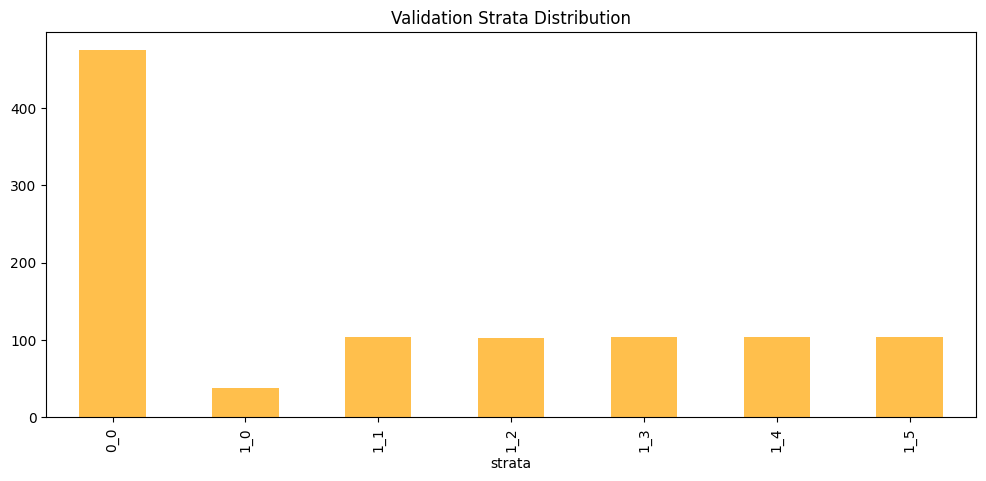

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
train_df["strata"].value_counts().sort_index().plot(kind="bar", color="blue", alpha=0.7)
plt.title("Train Strata Distribution")
plt.show()

plt.figure(figsize=(12,5))
val_df["strata"].value_counts().sort_index().plot(kind="bar", color="orange", alpha=0.7)
plt.title("Validation Strata Distribution")
plt.show()

Step 4: Dataset class, transforms, collate, and DataLoader preview.

/usr/local/lib/python3.11/dist-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


loading csvs...
train: 4102 val: 1026
images: torch.Size([2, 3, 512, 512])
masks: torch.Size([2, 1, 512, 512])
inst-lists: 2
first id: 5772 is_forged: 1
inst count sample0: 6
mask pixels sample0: 3823


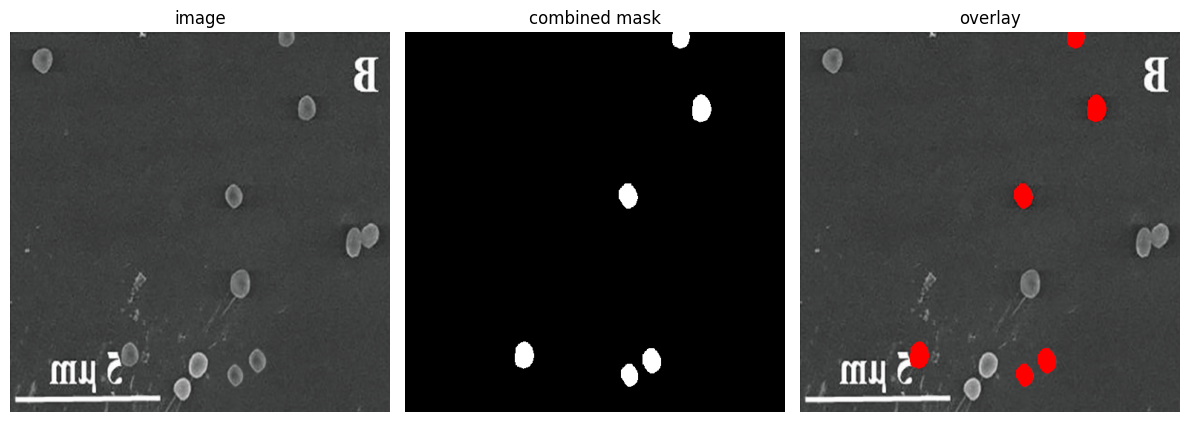

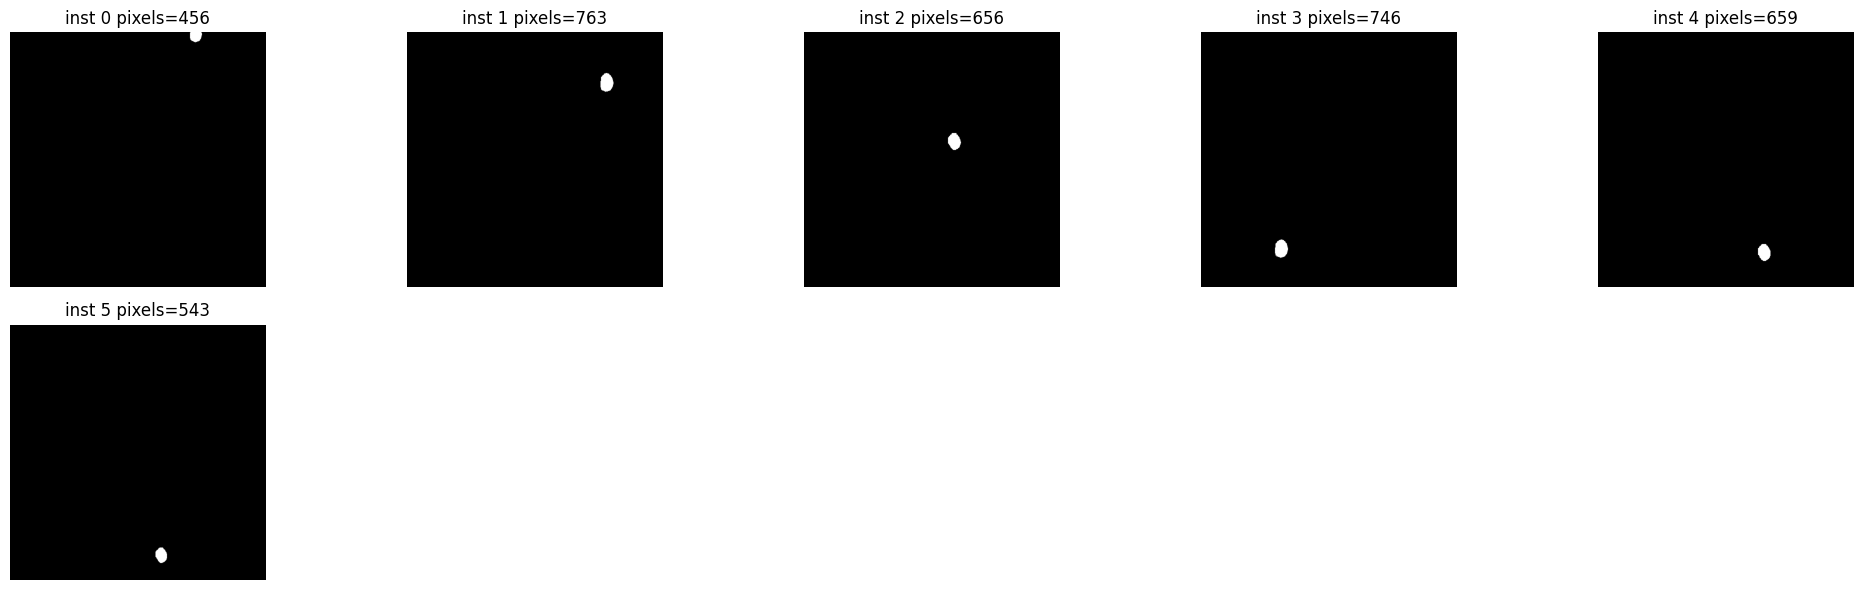

In [19]:
import os, json
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt

base_dir = Path("/kaggle/input/recodai-luc-scientific-image-forgery-detection")
train_csv = Path("/kaggle/working/train_split.csv")
val_csv = Path("/kaggle/working/val_split.csv")

def load_mask_list_np(mask_path: Path):
    a = np.load(mask_path)
    a = (a > 0).astype(np.uint8)
    if a.ndim == 2:
        return [a]
    if a.ndim == 3:
        return [a[c].astype(np.uint8) for c in range(a.shape[0]) if a[c].sum() > 0]
    raise ValueError(str(a.shape))

class ImageMaskDataset(Dataset):
    def __init__(self, df, out_size=(512,512), augment=False):
        self.df = df.reset_index(drop=True)
        self.out_size = out_size
        if augment:
            self.tf = A.Compose([
                A.Resize(out_size[0], out_size[1]),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.2),
                A.Rotate(limit=30, p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                A.OneOf([A.GaussNoise(p=0.3), A.GaussianBlur(p=0.3)], p=0.3),
                A.Normalize(),
                ToTensorV2()
            ])
        else:
            self.tf = A.Compose([
                A.Resize(out_size[0], out_size[1]),
                A.Normalize(),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = np.array(Image.open(row["image_path"]).convert("RGB"))
        h0, w0 = json.loads(row["shape"])
        if int(row["is_forged"]) == 1:
            insts = load_mask_list_np(Path(row["mask_path"]))
            combined = np.zeros((h0, w0), dtype=np.uint8)
            for m in insts:
                combined |= (m > 0).astype(np.uint8)
        else:
            combined = np.zeros((h0, w0), dtype=np.uint8)

        aug = self.tf(image=img, mask=combined)

        # Augmented image tensor (ToTensorV2 gives torch.Tensor)
        img_t = aug["image"]

        # Augmented mask may be torch.Tensor or numpy array depending on ToTensorV2;
        # convert robustly to numpy and ensure binary uint8
        mask_aug = aug["mask"]
        if isinstance(mask_aug, torch.Tensor):
            aug_mask_np = mask_aug.cpu().numpy()
        else:
            aug_mask_np = np.array(mask_aug)

        aug_mask_np = (aug_mask_np > 0).astype(np.uint8)
        mask_t = torch.tensor(aug_mask_np).unsqueeze(0).float()

        # extract instance masks from augmented combined mask (already at out_size)
        inst_masks_out = []
        n, labels = cv2.connectedComponents(aug_mask_np, connectivity=8)
        for lab in range(1, n):
            m = (labels == lab).astype(np.uint8)
            inst_masks_out.append(m)

        return {
            "image": img_t,
            "mask": mask_t,
            "inst_masks": inst_masks_out,
            "case_id": row["case_id"],
            "is_forged": int(row["is_forged"])
        }

def collate_for_batch(batch):
    imgs = torch.stack([b["image"] for b in batch], dim=0)
    masks = torch.stack([b["mask"] for b in batch], dim=0)
    insts = [b["inst_masks"] for b in batch]
    ids = [b["case_id"] for b in batch]
    forged_flags = torch.tensor([b["is_forged"] for b in batch], dtype=torch.uint8)
    return {"images": imgs, "masks": masks, "insts": insts, "case_ids": ids, "is_forged": forged_flags}

print("loading csvs...")
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
print("train:", len(train_df), "val:", len(val_df))

train_ds = ImageMaskDataset(train_df, out_size=(512,512), augment=True)
val_ds = ImageMaskDataset(val_df, out_size=(512,512), augment=False)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_for_batch, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, collate_fn=collate_for_batch, num_workers=0, pin_memory=True)

batch = next(iter(train_loader))
print("images:", batch["images"].shape)
print("masks:", batch["masks"].shape)
print("inst-lists:", len(batch["insts"]))
print("first id:", batch["case_ids"][0], "is_forged:", int(batch["is_forged"][0]))
print("inst count sample0:", len(batch["insts"][0]))
print("mask pixels sample0:", int(batch["masks"][0].sum().item()))

# quick visual alignment check for first sample
img_t = batch["images"][0].permute(1,2,0).cpu().numpy()
img_t = (img_t * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))
img_t = np.clip(img_t, 0, 1)
img_disp = (img_t * 255).astype(np.uint8)

mask_np = batch["masks"][0].squeeze(0).cpu().numpy().astype(np.uint8)
overlay = img_disp.copy()
overlay[mask_np==1] = (255,0,0)

plt.figure(figsize=(12,6))
plt.subplot(1,3,1); plt.imshow(img_disp); plt.title("image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask_np, cmap="gray"); plt.title("combined mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay); plt.title("overlay"); plt.axis("off")
plt.tight_layout()
plt.show()

if len(batch["insts"][0]) > 0:
    n = len(batch["insts"][0])
    cols = min(n, 5)
    rows = (n + cols - 1)//cols
    plt.figure(figsize=(4*cols, 3*rows))
    for i, m in enumerate(batch["insts"][0]):
        plt.subplot(rows, cols, i+1)
        plt.imshow(m, cmap="gray"); plt.title(f"inst {i} pixels={m.sum()}"); plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("no instance masks in first sample")

In [20]:
# Alignment checker: compares combined mask vs union(inst_masks) and visualizes mismatches
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import pandas as pd
from PIL import Image

USE_LOADER = True   # set False to recreate dataset locally (safer if loader not present)
SAMPLE_LIMIT = 500  # how many samples to check (set None to check all)
SHOW_MAX = 8        # how many mismatch examples to visualize
MISMATCH_PIXEL_THRESHOLD = 1  # treat any non-zero pixel diff as mismatch; raise it to e.g. 5 for tolerance

checked = 0
mismatch_examples = []
total = 0
ok_count = 0
forged_flag_violations = 0
shape_violations = 0

def visualize_mismatch(img_np, mask_np, union_np, diff_np, case_id, info):
    plt.figure(figsize=(12,6))
    plt.subplot(1,4,1); plt.imshow(img_np); plt.title(f"Image: {case_id}"); plt.axis("off")
    plt.subplot(1,4,2); plt.imshow(mask_np, cmap="gray"); plt.title("dataset combined mask"); plt.axis("off")
    plt.subplot(1,4,3); plt.imshow(union_np, cmap="gray"); plt.title("union(inst_masks)"); plt.axis("off")
    plt.subplot(1,4,4); plt.imshow(diff_np, cmap="hot"); plt.title(f"diff (xor) | {info}"); plt.axis("off")
    plt.tight_layout()
    plt.show()

# Try to use existing train_loader
if USE_LOADER and 'train_loader' in globals():
    loader = train_loader
    it = iter(loader)
    while True:
        try:
            batch = next(it)
        except StopIteration:
            break
        imgs = batch["images"].cpu()           # (B,3,H,W)
        masks = batch["masks"].cpu()           # (B,1,H,W)
        insts = batch["insts"]                 # list length B, each is list of (H,W) arrays
        case_ids = batch["case_ids"]
        is_forged = batch["is_forged"].cpu().numpy()
        bsize = imgs.shape[0]
        for i in range(bsize):
            total += 1
            img_np = imgs[i].permute(1,2,0).numpy()
            # try to un-normalize (approx) if values look normalized (-2..2)
            if img_np.max() <= 2.5:
                img_np = (img_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))
                img_np = np.clip(img_np, 0, 1)
            img_disp = (img_np*255).astype(np.uint8)

            mask_np = masks[i].squeeze(0).numpy().astype(np.uint8)  # (H,W)
            inst_list = insts[i]  # list of numpy arrays already at same size

            # union of instance masks
            if len(inst_list) == 0:
                union_np = np.zeros_like(mask_np, dtype=np.uint8)
            else:
                union_np = np.zeros_like(mask_np, dtype=np.uint8)
                for m in inst_list:
                    union_np |= (m > 0).astype(np.uint8)

            # checks
            if mask_np.shape != union_np.shape or mask_np.shape[0] != img_disp.shape[0] or mask_np.shape[1] != img_disp.shape[1]:
                shape_violations += 1
                info = f"shape mismatch: mask {mask_np.shape}, img {img_disp.shape[:2]}"
                if len(mismatch_examples) < SHOW_MAX:
                    diff_np = np.ones_like(mask_np)  # full diff (placeholder)
                    visualize_mismatch(img_disp, mask_np, union_np, diff_np, case_ids[i], info)
                continue

            diff = (mask_np ^ union_np).astype(np.uint8)
            diff_pixels = diff.sum()
            # forged flag check: if is_forged==0 but mask has pixels, or vice versa
            if is_forged[i] == 0 and mask_np.sum() > 0:
                forged_flag_violations += 1
            if is_forged[i] == 1 and mask_np.sum() == 0:
                forged_flag_violations += 1

            if diff_pixels > MISMATCH_PIXEL_THRESHOLD:
                mismatch_examples.append({
                    "case_id": case_ids[i],
                    "diff_pixels": int(diff_pixels),
                    "mask_pixels": int(mask_np.sum()),
                    "union_pixels": int(union_np.sum()),
                    "is_forged": int(is_forged[i])
                })
                if len(mismatch_examples) <= SHOW_MAX:
                    info = f"diff_pixels={int(diff_pixels)}, mask_px={int(mask_np.sum())}, union_px={int(union_np.sum())}"
                    visualize_mismatch(img_disp, mask_np, union_np, diff, case_ids[i], info)
            else:
                ok_count += 1

            checked += 1
            if SAMPLE_LIMIT and checked >= SAMPLE_LIMIT:
                break
        if SAMPLE_LIMIT and checked >= SAMPLE_LIMIT:
            break

else:
    # fallback: build a tiny dataset using train_split.csv and simple Dataset (no workers)
    df = pd.read_csv("/kaggle/working/train_split.csv")
    from PIL import Image
    def load_sample(row):
        img = np.array(Image.open(row["image_path"]).convert("RGB"))
        h0,w0 = json.loads(row["shape"])
        mask = np.zeros((h0,w0), dtype=np.uint8)
        if int(row["is_forged"])==1:
            arr = np.load(row["mask_path"])
            if arr.ndim==2:
                insts = [ (arr>0).astype(np.uint8) ]
            else:
                insts = [ (arr[c]>0).astype(np.uint8) for c in range(arr.shape[0]) ]
            for m in insts:
                mask |= m
        return img, mask, insts
    for idx,row in df.sample(frac=1, random_state=0).iterrows():
        img, mask_np, insts = load_sample(row)
        union_np = np.zeros_like(mask_np, dtype=np.uint8)
        for m in insts:
            union_np |= (m>0).astype(np.uint8)
        diff = (mask_np ^ union_np).astype(np.uint8)
        diff_pixels = diff.sum()
        total += 1
        if diff_pixels > MISMATCH_PIXEL_THRESHOLD and len(mismatch_examples) < SHOW_MAX:
            visualize_mismatch(img, mask_np, union_np, diff, row["case_id"], f"diff={diff_pixels}")
        if SAMPLE_LIMIT and total >= SAMPLE_LIMIT:
            break

# Summary
print("Checked samples:", total)
print("OK count (no diff):", ok_count)
print("Mismatches found:", len(mismatch_examples))
print("Forged flag violations (is_forged vs mask):", forged_flag_violations)
print("Shape violations:", shape_violations)
if len(mismatch_examples) > 0:
    print("First mismatch examples (summary):")
    for ex in mismatch_examples[:10]:
        print(ex)
else:
    print("No mismatches found (union(inst_masks) == combined mask) in checked samples.")

Checked samples: 500
OK count (no diff): 500
Mismatches found: 0
Forged flag violations (is_forged vs mask): 0
Shape violations: 0
No mismatches found (union(inst_masks) == combined mask) in checked samples.


vizualizations

---- Forged examples ----


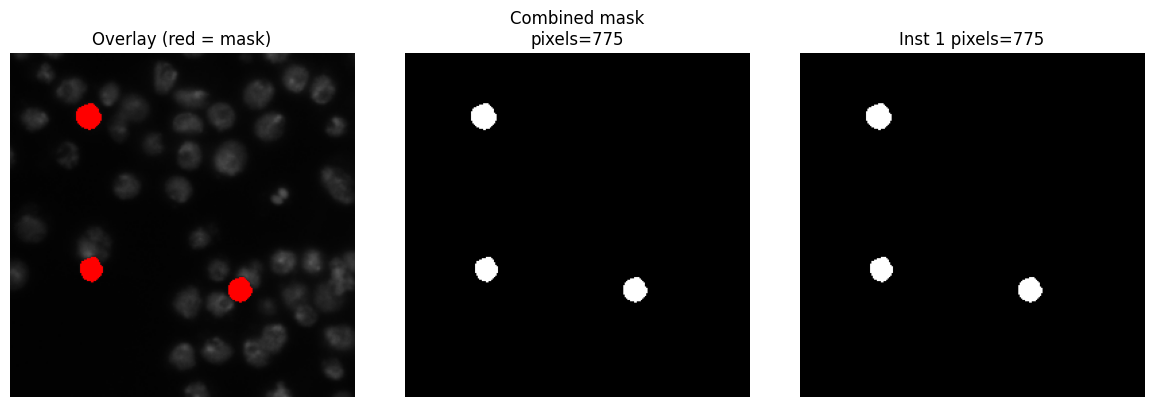

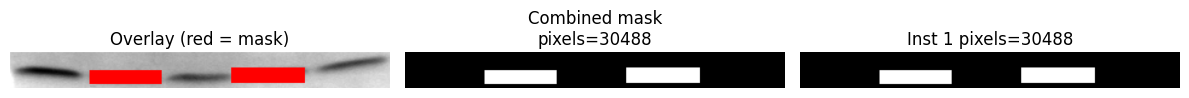

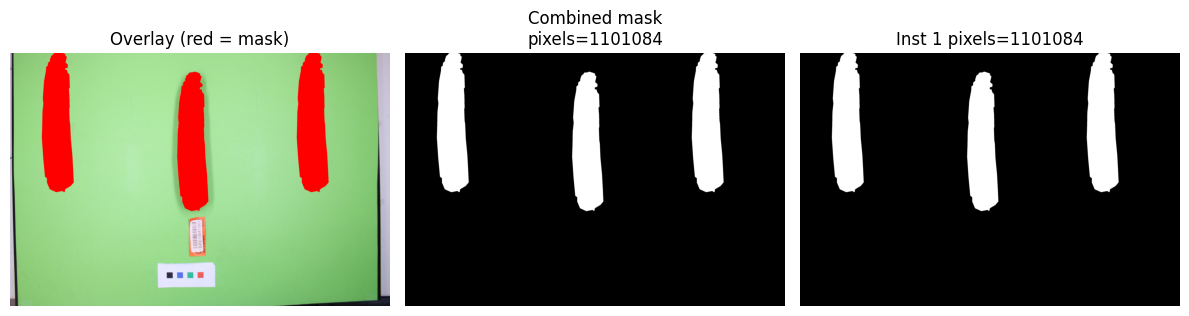

---- Authentic examples ----


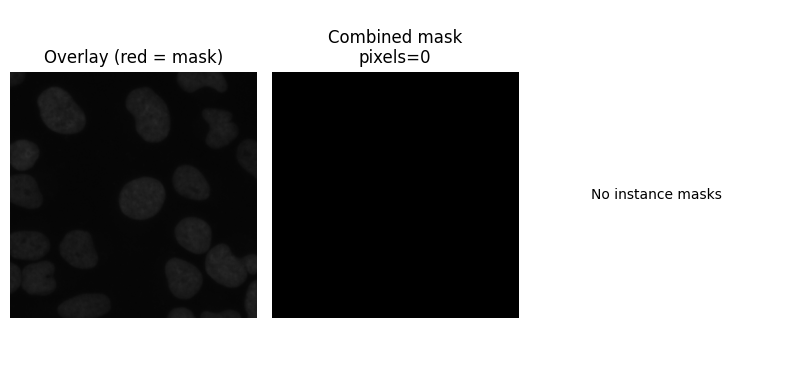

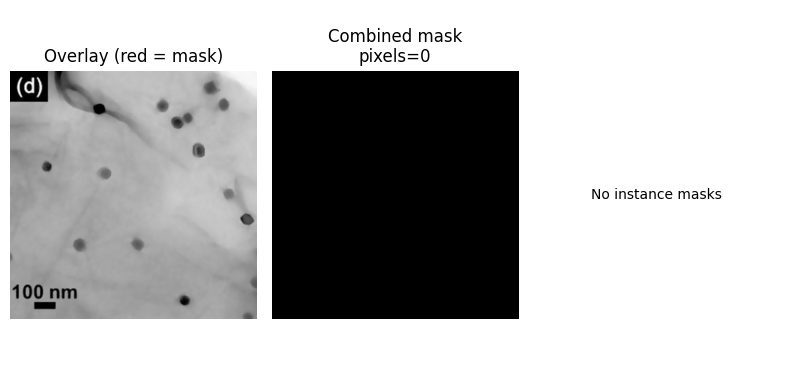

In [21]:
import json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

BASE = Path("/kaggle/input/recodai-luc-scientific-image-forgery-detection")
TRAIN_CSV = Path("/kaggle/working/train_split.csv")
MASK_DIR = BASE / "train_masks"

def load_mask_list(mask_path):
    m = np.load(mask_path)
    m = (m > 0).astype(np.uint8)
    if m.ndim == 2:
        return [m]
    if m.ndim == 3:
        return [m[c].astype(np.uint8) for c in range(m.shape[0]) if m[c].sum() > 0]
    raise ValueError(str(m.shape))

df = pd.read_csv(TRAIN_CSV)
df_sample_forged = df[df["is_forged"]==1].sample(3, random_state=2).reset_index(drop=True)
df_sample_auth = df[df["is_forged"]==0].sample(2, random_state=3).reset_index(drop=True)

def show_sample(row):
    img_path = Path(row["image_path"])
    img = np.array(Image.open(img_path).convert("RGB"))
    h,w = json.loads(row["shape"])
    if int(row["is_forged"])==1:
        insts = load_mask_list(Path(row["mask_path"]))
        combined = np.zeros((h,w), dtype=np.uint8)
        for m in insts:
            combined |= (m>0).astype(np.uint8)
    else:
        insts = []
        combined = np.zeros((h,w), dtype=np.uint8)

    fig, axs = plt.subplots(1, 2 + max(1, len(insts)), figsize=(4*(2+len(insts)), 4))
    axs[0].imshow(img); axs[0].axis("off"); axs[0].set_title(f"Image: {row['case_id']}")
    axs[1].imshow(combined, cmap="gray"); axs[1].axis("off"); axs[1].set_title(f"Combined mask\npixels={int(combined.sum())}")
    # overlay
    overlay = img.copy()
    if combined.sum()>0:
        overlay[combined==1] = (255,0,0)
    axs[1].imshow(combined, cmap="gray", alpha=0.45)
    axs[0].imshow(overlay); axs[0].set_title(f"Overlay (red = mask)")

    # show instance masks (if any)
    if len(insts)==0:
        axs[2].text(0.5,0.5,"No instance masks", ha='center', va='center'); axs[2].axis('off')
    else:
        for i, m in enumerate(insts):
            ax = axs[2+i]
            ax.imshow(m, cmap="gray"); ax.axis("off")
            ax.set_title(f"Inst {i+1} pixels={int(m.sum())}")
    plt.tight_layout()
    plt.show()

print("---- Forged examples ----")
for _, r in df_sample_forged.iterrows():
    show_sample(r)

print("---- Authentic examples ----")
for _, r in df_sample_auth.iterrows():
    show_sample(r)

Baseline Model

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    # (conv => BN => ReLU) * 2
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    # downsampling: maxpool + double conv
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x

class Up(nn.Module):
    # upsampling: transposed conv + concat skip + double conv
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)  # in_ch = skip_ch + up_ch

    def forward(self, x, skip):
        x = self.up(x)
        # pad if needed to match skip size
        diffY = skip.size(2) - x.size(2)
        diffX = skip.size(3) - x.size(3)
        if diffY != 0 or diffX != 0:
            x = F.pad(
                x,
                [diffX // 2, diffX - diffX // 2,
                 diffY // 2, diffY - diffY // 2],
            )
        x = torch.cat([skip, x], dim=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base_ch=32):
        super().__init__()
        self.inc   = DoubleConv(in_ch, base_ch)
        self.down1 = Down(base_ch, base_ch * 2)
        self.down2 = Down(base_ch * 2, base_ch * 4)
        self.down3 = Down(base_ch * 4, base_ch * 8)
        self.down4 = Down(base_ch * 8, base_ch * 16)

        self.up1 = Up(base_ch * 16, base_ch * 8)
        self.up2 = Up(base_ch * 8,  base_ch * 4)
        self.up3 = Up(base_ch * 4,  base_ch * 2)
        self.up4 = Up(base_ch * 2,  base_ch)

        self.outc = nn.Conv2d(base_ch, out_ch, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)      # (B, base)
        x2 = self.down1(x1)   # (B, 2*base)
        x3 = self.down2(x2)   # (B, 4*base)
        x4 = self.down3(x3)   # (B, 8*base)
        x5 = self.down4(x4)   # (B, 16*base)

        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)

        logits = self.outc(x)  # (B, out_ch, H, W)
        return logits

In [23]:
# CELL 1: TRAINING (LOSS-ONLY) — using local UNet (no pip)
import os, json, gc, time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm.auto import tqdm

# (UNet class must already be defined above this cell)

# -------------------------
# Hyperparams & paths
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 10
BATCH_SIZE = 4          # used when you create DataLoaders
LR = 1e-4
WEIGHT_DECAY = 1e-6
CHECKPOINT_DIR = Path("/kaggle/working/checkpoints")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

# loss weights
WEIGHT_BCE = 1.0
WEIGHT_DICE = 0.5
WEIGHT_FOCAL = 1.0
ALPHA_FOCAL = 0.25
GAMMA_FOCAL = 2.0

# -------------------------
# Instantiate model, opt, scheduler
# -------------------------
model = UNet(in_ch=3, out_ch=1, base_ch=32).to(DEVICE)

optim = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS, eta_min=1e-6)

# -------------------------
# Loss functions
# -------------------------
bce_loss = nn.BCEWithLogitsLoss(reduction="mean")

def dice_loss_logits(pred_logits, target, eps=1e-7):
    pred = torch.sigmoid(pred_logits)
    p = pred.view(pred.size(0), -1)
    t = target.view(target.size(0), -1)
    inter = (p * t).sum(dim=1)
    dice = (2. * inter + eps) / (p.sum(dim=1) + t.sum(dim=1) + eps)
    return 1.0 - dice.mean()

def focal_loss_logits(pred_logits, target, alpha=ALPHA_FOCAL, gamma=GAMMA_FOCAL):
    bce = F.binary_cross_entropy_with_logits(pred_logits, target, reduction="none")
    prob = torch.sigmoid(pred_logits)
    p_t = prob * target + (1 - prob) * (1 - target)
    alpha_factor = alpha * target + (1 - alpha) * (1 - target)
    modulating_factor = (1.0 - p_t).pow(gamma)
    loss = alpha_factor * modulating_factor * bce
    return loss.mean()

def total_loss_fn(pred_logits, target):
    return (
        WEIGHT_BCE * bce_loss(pred_logits, target)
        + WEIGHT_DICE * dice_loss_logits(pred_logits, target)
        + WEIGHT_FOCAL * focal_loss_logits(pred_logits, target)
    )

# -------------------------
# Training / validation loops
# -------------------------
def train_one_epoch(model, loader):
    model.train()
    running = 0.0
    n = 0
    pbar = tqdm(loader, desc="Train")
    for batch in pbar:
        imgs = batch["images"].to(DEVICE)
        masks = batch["masks"].to(DEVICE)   # (B,1,H,W)

        optim.zero_grad()
        logits = model(imgs)                # UNet forward
        loss = total_loss_fn(logits, masks)
        loss.backward()
        optim.step()

        running += loss.item() * imgs.size(0)
        n += imgs.size(0)
        pbar.set_postfix(train_loss=f"{running / n:.4f}")
    return running / max(1, n)

def validate_loss_only(model, loader):
    model.eval()
    running = 0.0
    n = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Val"):
            imgs = batch["images"].to(DEVICE)
            masks = batch["masks"].to(DEVICE)
            logits = model(imgs)
            loss = total_loss_fn(logits, masks)
            running += loss.item() * imgs.size(0)
            n += imgs.size(0)
    return running / max(1, n)

# -------------------------
# Main loop
# -------------------------
best_val = float("inf")
start = time.time()
for epoch in range(1, EPOCHS+1):
    print(f"\n=== Epoch {epoch}/{EPOCHS} ===")
    train_loss = train_one_epoch(model, train_loader)
    val_loss = validate_loss_only(model, val_loader)
    print(f"Epoch {epoch} Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # save epoch and best-by-val
    epoch_ckpt = CHECKPOINT_DIR / f"epoch{epoch}_train{train_loss:.4f}_val{val_loss:.4f}.pth"
    torch.save(
        {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optim_state": optim.state_dict(),
            "train_loss": train_loss,
            "val_loss": val_loss,
        },
        epoch_ckpt,
    )
    print("Saved:", epoch_ckpt)

    if val_loss < best_val:
        best_val = val_loss
        best_ckpt = CHECKPOINT_DIR / f"best_val_epoch{epoch}_val{val_loss:.4f}.pth"
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optim_state": optim.state_dict(),
                "train_loss": train_loss,
                "val_loss": val_loss,
            },
            best_ckpt,
        )
        print("Saved best-val:", best_ckpt)

    scheduler.step()
    gc.collect()
    torch.cuda.empty_cache()

print("Training finished. Time (min):", (time.time() - start) / 60)


=== Epoch 1/10 ===


Train:   0%|          | 0/2051 [00:00<?, ?it/s]

Val:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch 1 Train Loss: 0.7717 | Val Loss: 0.6660
Saved: /kaggle/working/checkpoints/epoch1_train0.7717_val0.6660.pth
Saved best-val: /kaggle/working/checkpoints/best_val_epoch1_val0.6660.pth

=== Epoch 2/10 ===


Train:   0%|          | 0/2051 [00:00<?, ?it/s]

Val:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch 2 Train Loss: 0.6319 | Val Loss: 0.6623
Saved: /kaggle/working/checkpoints/epoch2_train0.6319_val0.6623.pth
Saved best-val: /kaggle/working/checkpoints/best_val_epoch2_val0.6623.pth

=== Epoch 3/10 ===


Train:   0%|          | 0/2051 [00:00<?, ?it/s]

Val:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch 3 Train Loss: 0.6139 | Val Loss: 0.6559
Saved: /kaggle/working/checkpoints/epoch3_train0.6139_val0.6559.pth
Saved best-val: /kaggle/working/checkpoints/best_val_epoch3_val0.6559.pth

=== Epoch 4/10 ===


Train:   0%|          | 0/2051 [00:00<?, ?it/s]

Val:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch 4 Train Loss: 0.6059 | Val Loss: 0.6577
Saved: /kaggle/working/checkpoints/epoch4_train0.6059_val0.6577.pth

=== Epoch 5/10 ===


Train:   0%|          | 0/2051 [00:00<?, ?it/s]

Val:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch 5 Train Loss: 0.6009 | Val Loss: 0.6383
Saved: /kaggle/working/checkpoints/epoch5_train0.6009_val0.6383.pth
Saved best-val: /kaggle/working/checkpoints/best_val_epoch5_val0.6383.pth

=== Epoch 6/10 ===


Train:   0%|          | 0/2051 [00:00<?, ?it/s]

Val:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch 6 Train Loss: 0.5958 | Val Loss: 0.6380
Saved: /kaggle/working/checkpoints/epoch6_train0.5958_val0.6380.pth
Saved best-val: /kaggle/working/checkpoints/best_val_epoch6_val0.6380.pth

=== Epoch 7/10 ===


Train:   0%|          | 0/2051 [00:00<?, ?it/s]

Val:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.5939 | Val Loss: 0.6305
Saved: /kaggle/working/checkpoints/epoch7_train0.5939_val0.6305.pth
Saved best-val: /kaggle/working/checkpoints/best_val_epoch7_val0.6305.pth

=== Epoch 8/10 ===


Train:   0%|          | 0/2051 [00:00<?, ?it/s]

Val:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch 8 Train Loss: 0.5887 | Val Loss: 0.6344
Saved: /kaggle/working/checkpoints/epoch8_train0.5887_val0.6344.pth

=== Epoch 9/10 ===


Train:   0%|          | 0/2051 [00:00<?, ?it/s]

Val:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch 9 Train Loss: 0.5853 | Val Loss: 0.6278
Saved: /kaggle/working/checkpoints/epoch9_train0.5853_val0.6278.pth
Saved best-val: /kaggle/working/checkpoints/best_val_epoch9_val0.6278.pth

=== Epoch 10/10 ===


Train:   0%|          | 0/2051 [00:00<?, ?it/s]

Val:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch 10 Train Loss: 0.5850 | Val Loss: 0.6414
Saved: /kaggle/working/checkpoints/epoch10_train0.5850_val0.6414.pth
Training finished. Time (min): 106.41840339899063


In [24]:
# CELL 2: oF1 SWEEP — load best checkpoint, sweep thresholds & min sizes (UNet)
import numpy as np
import cv2
from tqdm.auto import tqdm
from pathlib import Path
from scipy.optimize import linear_sum_assignment
import torch, json

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_DIR = Path("/kaggle/working/checkpoints")
ckpts = sorted(CHECKPOINT_DIR.glob("best_val_epoch*.pth"))
if len(ckpts) == 0:
    ckpts = sorted(CHECKPOINT_DIR.glob("epoch*.pth"))
if len(ckpts) == 0:
    raise FileNotFoundError("No checkpoints found.")
BEST_CKPT = ckpts[-1]
print("Using checkpoint:", BEST_CKPT)

# reconstruct model identical to training
model = UNet(in_ch=3, out_ch=1, base_ch=32).to(DEVICE)
ck = torch.load(BEST_CKPT, map_location="cpu")
state = ck.get("model_state", ck.get("state_dict", ck))
new_state = {k.replace("module.", ""): v for k,v in state.items()}
missing, unexpected = model.load_state_dict(new_state, strict=False)
print("Missing keys:", len(missing), "Unexpected:", len(unexpected))
model.eval()

# helper metrics
def f1_pair(pred_mask, gt_mask):
    pred = pred_mask.flatten().astype(bool)
    gt = gt_mask.flatten().astype(bool)
    tp = np.logical_and(pred, gt).sum()
    fp = np.logical_and(pred, ~gt).sum()
    fn = np.logical_and(~pred, gt).sum()
    if (2*tp + fp + fn) == 0: return 0.0
    return 2*tp / (2*tp + fp + fn)

def oF1(pred_masks, gt_masks):
    if len(gt_masks)==0 and len(pred_masks)==0: return 1.0
    if len(gt_masks)==0: return 0.0
    if len(pred_masks)==0: return 0.0
    P = len(pred_masks); G = len(gt_masks)
    M = np.zeros((P,G))
    for i in range(P):
        for j in range(G):
            M[i,j] = f1_pair(pred_masks[i], gt_masks[j])
    if P < G:
        M = np.vstack([M, np.zeros((G-P,G))])
        P = G
    r,c = linear_sum_assignment(-M)
    matched = M[r,c].sum() / max(1, G)
    penalty = G / max(P,G)
    return matched * penalty

# instance extraction
def prob_to_instances(prob_map, thr, min_size):
    bw = (prob_map > thr).astype(np.uint8)
    num, labels = cv2.connectedComponents(bw, connectivity=8)
    insts = []
    for lab in range(1, num):
        m = (labels==lab).astype(np.uint8)
        if m.sum() >= min_size:
            insts.append(m)
    return insts

def evaluate_of1(model, loader, thr, min_size):
    model.eval()
    scores = []
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Eval thr={thr} min={min_size}"):
            imgs = batch["images"].to(DEVICE)
            gt_insts = batch["insts"]  # list of lists of numpy arrays
            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy().squeeze(1)  # (B,H,W)
            for i in range(probs.shape[0]):
                pred_insts = prob_to_instances(probs[i], thr, min_size)
                gt_insts_i = [(g>0).astype(np.uint8) for g in gt_insts[i]]
                scores.append(oF1(pred_insts, gt_insts_i))
    return float(np.mean(scores)) if len(scores)>0 else 0.0

thresholds = [0.30]
min_sizes  = [16]

best_score = -1.0
best_thr = None
best_ms = None
results = []

for thr in thresholds:
    for ms in min_sizes:
        score = evaluate_of1(model, val_loader, thr, ms)
        print(f"THR={thr:.2f} MIN={ms} => oF1={score:.4f}")
        results.append({"thr": thr, "min_size": ms, "of1": score})
        if score > best_score:
            best_score = score
            best_thr = thr
            best_ms = ms

print("BEST oF1:", best_score, "THR:", best_thr, "MIN:", best_ms)

out = {
    "best_threshold": float(best_thr),
    "best_min_size": int(best_ms),
    "best_of1": float(best_score),
    "results": results,
}
with open("/kaggle/working/best_params.json", "w") as f:
    json.dump(out, f, indent=2)
print("Saved /kaggle/working/best_params.json")

Using checkpoint: /kaggle/working/checkpoints/best_val_epoch9_val0.6278.pth
Missing keys: 0 Unexpected: 0


Eval thr=0.3 min=16:   0%|          | 0/513 [00:00<?, ?it/s]

THR=0.30 MIN=16 => oF1=0.2190
BEST oF1: 0.2189754635392886 THR: 0.3 MIN: 16
Saved /kaggle/working/best_params.json


Predictions on Test dataset

<!-- if forged it predicted as "[1234,8,122,12]" -->

In [25]:
# CELL 3: INFERENCE + RLE SUBMISSION (uses best_params.json, UNet)
import json
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import torch
from tqdm.auto import tqdm
from IPython.display import FileLink

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BASE_DIR = Path("/kaggle/input/recodai-luc-scientific-image-forgery-detection")
TEST_DIR = BASE_DIR / "test_images"
SAMPLE_SUB = BASE_DIR / "sample_submission.csv"

OUT_CSV = Path("/kaggle/working/submission.csv")
CKPT_DIR = Path("/kaggle/working/checkpoints")
BP = Path("/kaggle/working/best_params.json")

IMG_SIZE = (512, 512)
MEAN = np.array([0.485, 0.456, 0.406])
STD  = np.array([0.229, 0.224, 0.225])

# -------------------------
# load best params
# -------------------------
if BP.exists():
    bp = json.load(open(BP))
    THRESH = float(bp.get("best_threshold", 0.3))
    MIN_COMPONENT_SIZE = int(bp.get("best_min_size", 16))
else:
    THRESH = 0.2
    MIN_COMPONENT_SIZE = 1

# -------------------------
# load best checkpoint
# -------------------------
ckpts = sorted(CKPT_DIR.glob("best_val_epoch*.pth"))
if len(ckpts) == 0:
    ckpts = sorted(CKPT_DIR.glob("epoch*.pth"))
if len(ckpts) == 0:
    raise FileNotFoundError("No checkpoints found in /kaggle/working/checkpoints")

BEST_CKPT = ckpts[-1]
print("Using checkpoint:", BEST_CKPT)
ck = torch.load(BEST_CKPT, map_location="cpu")
state = ck.get("model_state", ck.get("state_dict", ck))
state = {k.replace("module.", ""): v for k, v in state.items()}

# -------------------------
# rebuild UNet (same as training)
# -------------------------
model = UNet(in_ch=3, out_ch=1, base_ch=32).to(DEVICE)
missing, unexpected = model.load_state_dict(state, strict=False)
print("Loaded checkpoint -> missing:", len(missing), "unexpected:", len(unexpected))
model.eval()

# -------------------------
# RLE encoder: ONE mask -> ONE JSON array string
# -------------------------
def rle_encode_numpy(mask: np.ndarray) -> str:
    """
    Encode binary mask (H,W) into JSON-style RLE string.
    Returns e.g. "[123, 4, 567, 8]".
    """
    flat = mask.T.flatten().astype(np.uint8)  # Fortran order: transpose first
    dots = np.where(flat == 1)[0]
    if len(dots) == 0:
        return "authentic"

    run = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run.extend((int(b + 1), 0))
        run[-1] += 1
        prev = b

    return json.dumps([int(x) for x in run])

# -------------------------
# Convert prob map -> connected components -> union mask
# -------------------------
def prob_to_union_mask(prob_map: np.ndarray, thr: float, min_size: int) -> np.ndarray:
    """
    Threshold prob_map and keep union of all components >= min_size.
    Returns a single binary mask (H,W) with 0/1.
    """
    bw = (prob_map > thr).astype(np.uint8)
    if bw.sum() == 0:
        return np.zeros_like(bw, dtype=np.uint8)

    num, labels = cv2.connectedComponents(bw, connectivity=8)
    union = np.zeros_like(bw, dtype=np.uint8)
    for lab in range(1, num):
        m = (labels == lab).astype(np.uint8)
        if m.sum() >= min_size:
            union[m == 1] = 1
    return union

# -------------------------
# Inference for one image: returns "authentic" OR RLE string
# -------------------------
def infer_image(img_path: Path) -> str:
    img = np.array(Image.open(img_path).convert("RGB"))
    h0, w0 = img.shape[:2]

    # resize + normalize
    img_resized = np.array(
        Image.fromarray(img).resize((IMG_SIZE[1], IMG_SIZE[0]))
    )
    img_norm = (img_resized / 255.0 - MEAN) / STD
    t = torch.tensor(
        img_norm.transpose(2, 0, 1),
        dtype=torch.float32
    ).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = model(t)
        prob = torch.sigmoid(logits)[0, 0].cpu().numpy()  # (H, W) at IMG_SIZE

    # union mask in model resolution
    mask_small = prob_to_union_mask(prob, thr=THRESH, min_size=MIN_COMPONENT_SIZE)

    if mask_small.sum() == 0:
        return "authentic"

    # resize mask back to original size
    pil_m = Image.fromarray((mask_small * 255).astype(np.uint8))
    m_big = pil_m.resize((w0, h0), resample=Image.NEAREST)
    mask_big = (np.array(m_big) > 127).astype(np.uint8)

    # final single RLE string
    return rle_encode_numpy(mask_big)

# -------------------------
# Run inference over TEST_DIR
# -------------------------
files = sorted(
    [p for p in TEST_DIR.iterdir()
     if p.suffix.lower() in (".png", ".jpg", ".jpeg", ".tif", ".tiff")]
)
print("Num test images found:", len(files))

rows = []
for p in tqdm(files, desc="Predict"):
    ann = infer_image(p)  # "authentic" or RLE string
    rows.append({
        "case_id": str(p.stem),   # keep as string for merge
        "annotation": ann
    })

df = pd.DataFrame(rows)
df["case_id"] = df["case_id"].astype(str)

# -------------------------
# Align with sample_submission to guarantee correct IDs & row count
# -------------------------
sample_sub = pd.read_csv(SAMPLE_SUB)
sample_sub["case_id"] = sample_sub["case_id"].astype(str)

submission = sample_sub[["case_id"]].merge(df, on="case_id", how="left")
submission["annotation"] = submission["annotation"].fillna("authentic")

submission.to_csv(OUT_CSV, index=False)
print("Saved submission:", OUT_CSV)
display(FileLink(str(OUT_CSV)))
print(submission.head())

Using checkpoint: /kaggle/working/checkpoints/best_val_epoch9_val0.6278.pth
Loaded checkpoint -> missing: 0 unexpected: 0
Num test images found: 1


Predict:   0%|          | 0/1 [00:00<?, ?it/s]

Saved submission: /kaggle/working/submission.csv


/kaggle/working/submission.csv

  case_id annotation
0      45  authentic
